# Background

Honey bees are essential for the pollination of flowers, fruits and vegetables, and support about 20 billion dollars worth of crop production in the U.S. alone and 170 billion dollars in crops worldwide annually. They are one of the most important agricultural commodities in the world. However, over the past 15 years, bee colonies have been disappearing. Some regions have seen losses of up to 90%.

The main reasons for global bees’ decline are industrial agriculture, parasites/pathogens and climate change. The loss of biodiversity, destruction of habitat and lack of forage due to monocultures and bee-killing pesticides are particular threats for honeybees and wild pollinators.

There are efforts being put forth by researchers, farmers, and beekeepers worldwide to save the bee population.
While many indications of hive strength and health are visible on the inside of the hive, frequent check-ups are time consuming and disruptive to the bees’ workflow and hive in general. By investigating the bees that leave the hive, we can gain a more complete understanding of the hive itself.


## Objective

Being able to detect problematic characteristics on the bees that leave the hive (through images of bees), we can help saving our bees faster. My main goal is to train machine learning models to classify bees' health statuses, paving the way for more intelligent hive monitoring in general.

Down the road, if I can develop a mobile app that can allow users to quickly upload their bee pictures and automatically tell them what subspecies it is and/or what is happening to it, many bee colonies, along with time and financial resources, will be saved.


## Data

My data source is from Kaggle: https://www.kaggle.com/jenny18/honey-bee-annotated-images.

There are multiple csv files which I will put to use.

## Loading datasets 

In [1]:
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

Using TensorFlow backend.
C:\Users\vungu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vungu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vungu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vungu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
bees=pd.read_csv('bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

In [3]:
# Global variables
img_folder='bee_imgs/bee_imgs/'
img_width=100
img_height=100
img_channels=3

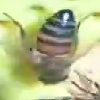

In [4]:
from keras.preprocessing import image

pictures3 = image.load_img(img_folder+'041_067.png',target_size=(100,100))
pictures3

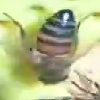

In [5]:
X_pics = [image.load_img(img_folder+img_name, target_size=(100,100)) for img_name in bees['file']]
X_pics[3]

In [6]:
X = [np.array(image.img_to_array(i)) for i in X_pics]
X = [i/255.0 for i in X]

In [120]:
# doing a label assignment by using a sparse matrix utilizing the keras util library
y_keys = {'healthy': np.array([1,0,0,0,0,0]),
          'few varrao, hive beetles': np.array([0,1,0,0,0,0]),
          'Varroa, Small Hive Beetles': np.array([0,0,1,0,0,0]),
          'ant problems': np.array([0,0,0,1,0,0]),
          'hive being robbed': np.array([0,0,0,0,1,0]),
          'missing queen': np.array([0,0,0,0,0,1])}
y = [y_keys[i] for i in bees.health]

In [8]:
bees.dtypes

datetime           datetime64[ns]
file                       object
location                   object
zip code                    int64
subspecies               category
health                   category
pollen_carrying              bool
caste                    category
dtype: object

Let's check the number of columns and rows

In [10]:
bees.shape

(5172, 8)

There are 5172 rows and 8 columns. Let's look at the data:

In [11]:
bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


# Data Exploration

## 1.1. Checking for missing data

In [12]:
bees.isnull().mean()*100

datetime           0.0
file               0.0
location           0.0
zip code           0.0
subspecies         0.0
health             0.0
pollen_carrying    0.0
caste              0.0
dtype: float64

There is no missing data. Let's look at the image data

In [13]:
def read_img(file):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file name without full path
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

# Cannot impute nans, drop them
bees.dropna(inplace=True)

# Some image files don't exist. Leave only bees with available images.
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
bees = bees[img_exists]

bees.head()


,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


## 1.2. Checking whether the number of image files match the image list

In [14]:
images_file = list(os.listdir(img_folder))
print('Number of image files: {}'.format(len(images_file)))

Number of image files: 5172


## 1.3. Checking whether image files match the image list

In [15]:
bees_file = list(bees['file'])
print('Matching image names: {}'.format(len(set(bees_file).intersection(images_file))))

Matching image names: 5172


No problem. All image files match the image list.

## 2. Location

Let's check where these bee image came from:

In [16]:
location = bees.groupby(['zip code'])['location'].value_counts()
location

zip code  location            
3431      Keene, NH, USA            92
30607     Athens, GA, USA          579
          Athens, Georgia, USA     472
50315     Des Moines, IA, USA      973
70115     New Orleans, LA, USA     170
77511     Alvin, TX, USA           737
95070     Saratoga, CA, USA       2000
95124     San Jose, CA, USA        149
Name: location, dtype: int64

`Athens, GA, USA` is the same as `Athens, Georgia, USA` so I'll modify the data so that the location name is the same for both.

In [17]:
bees.location = bees.location.replace({'Athens, Georgia, USA': 'Athens, GA, USA'})

In [18]:
location = bees.groupby(['zip code'])['location'].value_counts()
location

zip code  location            
3431      Keene, NH, USA            92
30607     Athens, GA, USA         1051
50315     Des Moines, IA, USA      973
70115     New Orleans, LA, USA     170
77511     Alvin, TX, USA           737
95070     Saratoga, CA, USA       2000
95124     San Jose, CA, USA        149
Name: location, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

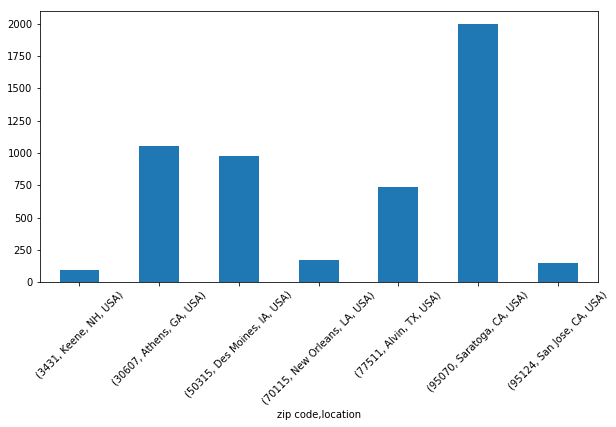

In [19]:
bees.groupby(['zip code'])['location'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=45)

Most of the images are captured in `Saratoga, California` (95070), followed by `Athens, Georgia` (30607) and `Des Moines, Iowa` (50315). 

## 3. Subspecies 

Let's take a look at the subspecies distribution

In [20]:
a = bees.groupby(['location']).subspecies.value_counts()
a

location              subspecies           
Alvin, TX, USA        Italian honey bee         457
                      -1                        251
                      VSH Italian honey bee      29
Athens, GA, USA       Italian honey bee         579
                      1 Mixed local stock 2     472
Des Moines, IA, USA   Carniolan honey bee       501
                      Russian honey bee         435
                      Western honey bee          37
Keene, NH, USA        Russian honey bee          92
New Orleans, LA, USA  VSH Italian honey bee     170
San Jose, CA, USA     -1                        149
Saratoga, CA, USA     Italian honey bee        1972
                      -1                         28
Name: subspecies, dtype: int64

In [21]:
bees.subspecies.unique()

[-1, Italian honey bee, VSH Italian honey bee, Carniolan honey bee, Russian honey bee, 1 Mixed local stock 2, Western honey bee]
Categories (7, object): [-1, Italian honey bee, VSH Italian honey bee, Carniolan honey bee, Russian honey bee, 1 Mixed local stock 2, Western honey bee]

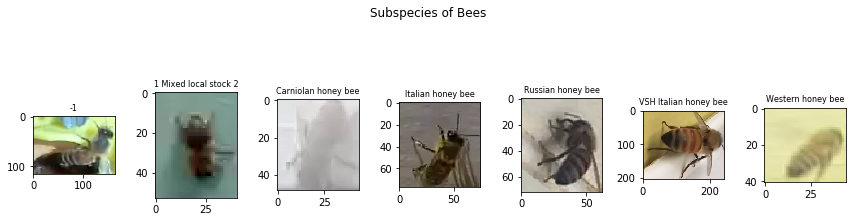

In [22]:
# select the first subspecies titles
subspecies = bees.subspecies.cat.categories
f, ax = plt.subplots(nrows=1, ncols=subspecies.size, figsize=(12,4))

i = 0
for s in subspecies:
    if s == 'healthy': 
        continue
    file = img_folder + bees[bees.subspecies == s].iloc[0]['file']
    im = imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1
    
plt.suptitle('Subspecies of Bees')
plt.tight_layout()
plt.show()

In [23]:
subs = bees.groupby(['subspecies'])['subspecies'].value_counts()
subs

subspecies             subspecies           
-1                     -1                        428
1 Mixed local stock 2  1 Mixed local stock 2     472
Carniolan honey bee    Carniolan honey bee       501
Italian honey bee      Italian honey bee        3008
Russian honey bee      Russian honey bee         527
VSH Italian honey bee  VSH Italian honey bee     199
Western honey bee      Western honey bee          37
Name: subspecies, dtype: int64

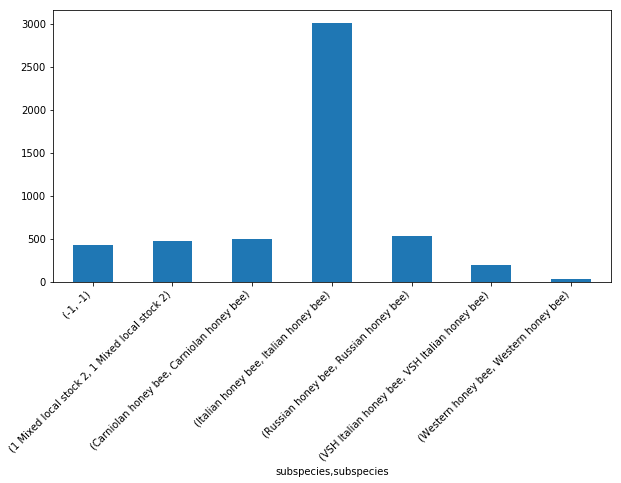

In [24]:
bees.groupby(['subspecies'])['subspecies'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [27]:
def draw_subspecies(var, cols=5):
    categories = (bees.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories), ncols=cols, figsize=(2*cols, 2*len(categories)))
    for i, cat in enumerate(categories):
        subspecies = bees[bees[var]==cat].sample(cols)
        for j in range(0, cols):
            file = img_folder + subspecies.iloc[j]['file']
            im = imageio.imread(file)
            ax[i,j].imshow(im)
            ax[i,j].set_title(cat, fontsize=9)
            
    plt.tight_layout()
    plt.show()

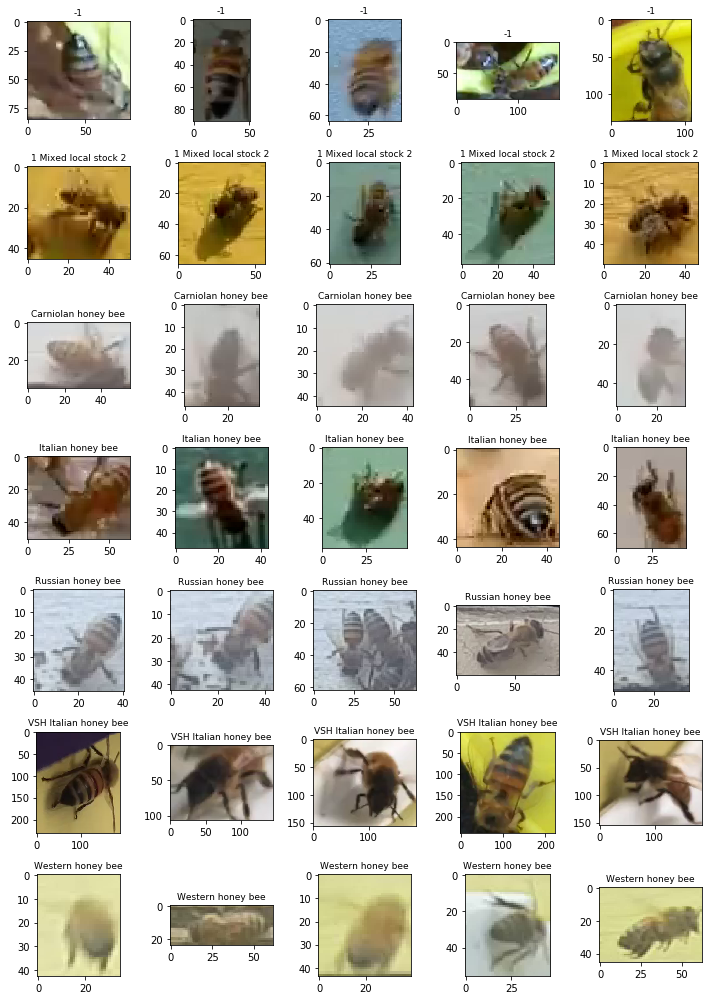

In [28]:
draw_subspecies('subspecies', cols=5)

## 4. Health

Let's take a look at the health distribution

In [29]:
health_status = bees.groupby(['health'])['health'].value_counts()
health_status

health                      health                    
Varroa, Small Hive Beetles  Varroa, Small Hive Beetles     472
ant problems                ant problems                   457
few varrao, hive beetles    few varrao, hive beetles       579
healthy                     healthy                       3384
hive being robbed           hive being robbed              251
missing queen               missing queen                   29
Name: health, dtype: int64

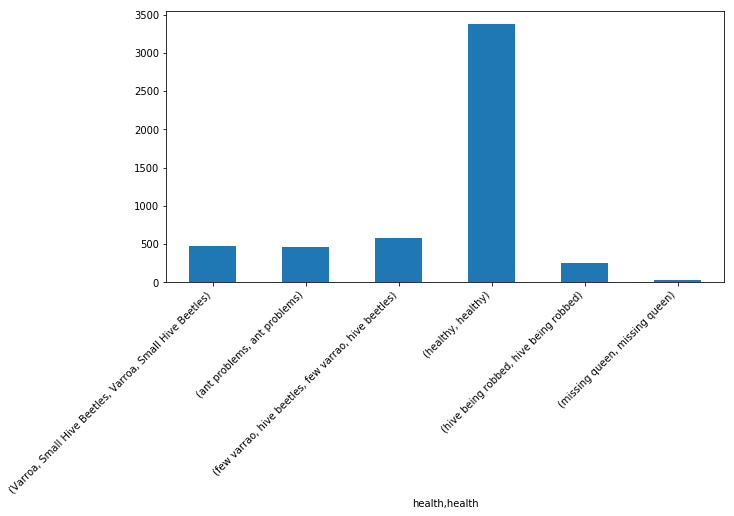

In [30]:
health_status.plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Majority of the data consists of `healthy` bees (3384). `missing queen` has the least amount of images (29), followed by `hive being robed` (251), and `ant problems` (457). This is a highly unbalanced dataset that needed to be addressed.

### Let's take a look at the healthy bees:

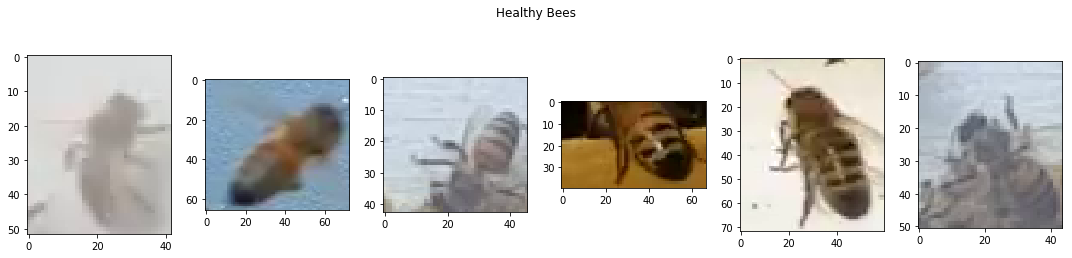

In [31]:
ncols = 6
healthy = bees[bees.health == 'healthy'].sample(ncols)

f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15,4))
for i in range(0,6):
    file = img_folder + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))
    
plt.suptitle('Healthy Bees')
plt.tight_layout()
plt.show()

### And sick bees:

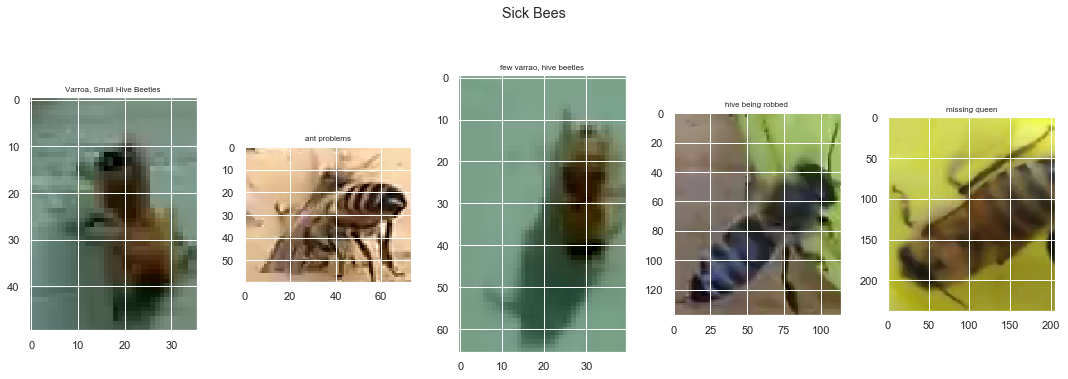

In [239]:
health_status = bees.health.cat.categories

f, ax = plt.subplots(1, health_status.size-1, figsize=(15,6))
i = 0
for status in health_status:
    if status == 'healthy':
        continue
    bee = bees[bees.health == status].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + bee['file']))
    ax[i].set_title(bee.health, fontsize=8)
    i+=1
    
plt.suptitle('Sick Bees')
plt.tight_layout()
plt.show()

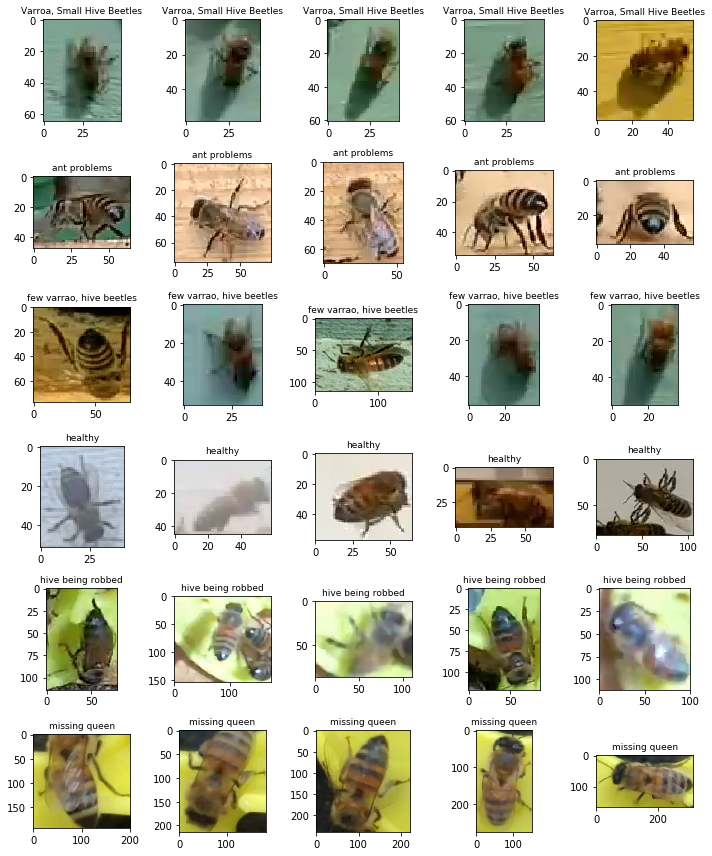

In [33]:
draw_subspecies('health', cols=5)

## 5. Subspecies and Health:

In [34]:
subs_health = bees.groupby(['subspecies'])['health'].value_counts()
subs_health

subspecies             health                    
-1                     hive being robbed              251
                       healthy                        177
1 Mixed local stock 2  Varroa, Small Hive Beetles     472
Carniolan honey bee    healthy                        501
Italian honey bee      healthy                       1972
                       few varrao, hive beetles       579
                       ant problems                   457
Russian honey bee      healthy                        527
VSH Italian honey bee  healthy                        170
                       missing queen                   29
Western honey bee      healthy                         37
Name: health, dtype: int64

The majority of images are of `healthy Italian honey bee` (1972), followed by `few varrao, hive beetles` `Italian honey bee` (579), `healthy Russian honey bee` (527), and `healthy Carniolan honey bee` (501). The unknown species are either `healthy` (177) or `hive being robbed` (251).

## 6. Pollen Carrying

Next, let's check the pollen carrying distribution

In [35]:
pollen = bees.groupby(['pollen_carrying'])['pollen_carrying'].value_counts()
pollen

pollen_carrying  pollen_carrying
False            False              5154
True             True                 18
Name: pollen_carrying, dtype: int64

Majority of the images is of non pollen carrying (5154 out of 5172). I won't try to predict this variable, as the data is highly skewed.

Let's take a look at `caste`:

## 7. Caste

In [36]:
caste = bees.groupby(['caste'])['caste'].value_counts()
caste

caste   caste 
worker  worker    5172
Name: caste, dtype: int64

All the bees are of the `worker` caste. 

We used a simple model. We separated 20% of the data for testing. From the training data, 80% is used for actual training and 20% for testing.
The data is unbalanced with respect of the classes of subspecies.
The accuracy of the training set obtained after only 5 epochs was 0.86, with a loss of 0.3.
The accuracy of the validation set remained around 0.89 and the loss increased to 0.27 after 3rd epoch.

Adding additional data will only slightly increase the accuracy of the training set (it is already very good).
To reduce the loss of the validation set (which is a sign of overfitting), we can have three strategies:

add Dropout layers;
introduce strides;
modify the learning rate during the training;

# CNN model for Bee Health Classification

In [58]:
bees.health.unique()

[hive being robbed, healthy, few varrao, hive beetles, ant problems, missing queen, Varroa, Small Hive Beetles]
Categories (6, object): [hive being robbed, healthy, few varrao, hive beetles, ant problems, missing queen, Varroa, Small Hive Beetles]

In [72]:
X = np.stack(bees['file'].apply(read_img))
X = [i/255.0 for i in X]

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\vungu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sam

In [156]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)

In [208]:
from keras.layers import Dense, Dropout, Activation, Flatten

# conv-->pool-->conv patterns
def train_cnn0():
    # to combat overfitting, better optimization for CNN, we'll be using Batch normalization prior to activation
    model = Sequential()
    
    #3x3 matrix with 5 feature maps in total, conventional 3d array for colored img, RBG. 255 in term of intensity max/min
    model.add(Conv2D(5,3,3, input_shape=(img_width, img_height,3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    model.add(Conv2D(11,3,3, activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    # 3rd convo layer with more feature filter size, 21 for better dectection
    model.add(Conv2D(21,3,3, activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    # flattening to input the fully connected layers
    model.add(Flatten())
    
    # dense layer section with hidden layer 200
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    
    # smaller learning rate to optimize better
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [209]:
model1 = train_cnn0()
training1 = model1.fit(np.array(X_train), np.array(Y_train), validation_data= (np.array(X_val), np.array(Y_val)), verbose=True, shuffle=True, epochs=50)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(100, 100,...)`
  if __name__ == '__main__':
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), activation="relu")`
  del sys.path[0]
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`


Train on 3309 samples, validate on 828 samples
Epoch 1/50
3309/3309 [==============================] - 15s 5ms/step - loss: 1.1961 - accuracy: 0.6525 - val_loss: 1.1516 - val_accuracy: 0.6546
Epoch 2/50
3309/3309 [==============================] - 15s 5ms/step - loss: 1.1437 - accuracy: 0.6543 - val_loss: 1.1594 - val_accuracy: 0.6546
Epoch 3/50
3309/3309 [==============================] - 16s 5ms/step - loss: 1.1455 - accuracy: 0.6543 - val_loss: 1.1325 - val_accuracy: 0.6546
Epoch 4/50
3309/3309 [==============================] - 17s 5ms/step - loss: 1.1388 - accuracy: 0.6543 - val_loss: 1.1292 - val_accuracy: 0.6546
Epoch 5/50
3309/3309 [==============================] - 16s 5ms/step - loss: 1.1315 - accuracy: 0.6543 - val_loss: 1.1196 - val_accuracy: 0.6546
Epoch 6/50
3309/3309 [==============================] - 16s 5ms/step - loss: 1.0512 - accuracy: 0.6543 - val_loss: 1.0067 - val_accuracy: 0.6546
Epoch 7/50
3309/3309 [==============================] - 15s 5ms/step - loss: 0.8866

### Evaluate model accuracy and loss

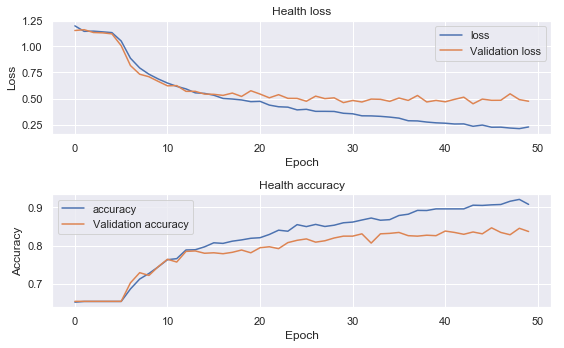

In [210]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training1.history['loss'], label='loss')
ax[0].plot(training1.history['val_loss'], label='Validation loss')
ax[0].set_title('Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training1.history['accuracy'], label='accuracy')
ax[1].plot(training1.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

### Test accuracy and loss

In [236]:
def test_accuracy_report(model):
    predicted = model.predict(np.array(X_test))
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(np.array(Y_test), axis=1)
    target_names = ['healthy', 'few varrao, hive beetles', 'Varroa, Small Hive Beetles', 'ant problems', 'hive being robbed', 'missing queen']
    print(metrics.classification_report(test_truth, test_predicted, target_names=target_names))
    test_res = model.evaluate(np.array(X_test), np.array(Y_test), verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [237]:
test_accuracy_report(model1)

                            precision    recall  f1-score   support

                   healthy       0.91      0.92      0.92       677
  few varrao, hive beetles       0.65      0.59      0.62       116
Varroa, Small Hive Beetles       0.72      0.66      0.69        95
              ant problems       0.79      0.85      0.81        91
         hive being robbed       0.46      0.50      0.48        50
             missing queen       1.00      0.50      0.67         6

                 micro avg       0.83      0.83      0.83      1035
                 macro avg       0.75      0.67      0.70      1035
              weighted avg       0.83      0.83      0.83      1035

Loss function: 0.5219892219644814, accuracy: 0.8318840861320496


This model looks decent but has a small overfitting problem. I will add `BatchNormalization` and tweak the filters to see if it can help reducing the validation loss and help with the overfitting problem.


## Adding BatchNormalization and Changing Filter Sizes

In [74]:
from keras.layers import Dense, Dropout, Activation, Flatten

# conv-->pool-->conv patterns
def train_cnn():
    # to combat overfitting, better optimization for CNN, we'll be using Batch normalization prior to activation
    model = Sequential()
    
    #3x3 matrix with 11 feature maps in total, conventional 3d array for colored img, RBG. 255 in term of intensity max/min
    model.add(Conv2D(11,3,3, input_shape=(img_width, img_height,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    model.add(Conv2D(21,3,3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    # 3rd convo layer with more feature filter size, 41 for better dectection
    model.add(Conv2D(41,3,3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    # flattening to input the fully connected layers
    model.add(Flatten())
    
    # dense layer section with hidden layer 200
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    
    # smaller learning rate to optimize better
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)

In [76]:
model4 = train_cnn()
training4 = model4.fit(np.array(X_train), np.array(Y_train), validation_data= (np.array(X_val), np.array(Y_val)), verbose=True, shuffle=True, epochs=50)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(100, 100,...)`
  if __name__ == '__main__':
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`
  
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(41, (3, 3), activation="relu")`


Train on 3309 samples, validate on 828 samples
Epoch 1/50
3309/3309 [==============================] - 41s 12ms/step - loss: 0.6662 - accuracy: 0.7969 - val_loss: 1.7660 - val_accuracy: 0.6546
Epoch 2/50
3309/3309 [==============================] - 42s 13ms/step - loss: 0.2829 - accuracy: 0.8824 - val_loss: 1.7561 - val_accuracy: 0.6546
Epoch 3/50
3309/3309 [==============================] - 40s 12ms/step - loss: 0.2213 - accuracy: 0.9087 - val_loss: 1.8039 - val_accuracy: 0.0447
Epoch 4/50
3309/3309 [==============================] - 39s 12ms/step - loss: 0.1898 - accuracy: 0.9278 - val_loss: 2.0395 - val_accuracy: 0.6546
Epoch 5/50
3309/3309 [==============================] - 41s 12ms/step - loss: 0.1734 - accuracy: 0.9287 - val_loss: 5.1289 - val_accuracy: 0.6546
Epoch 6/50
3309/3309 [==============================] - 40s 12ms/step - loss: 0.1311 - accuracy: 0.9492 - val_loss: 24.0754 - val_accuracy: 0.0882
Epoch 7/50
3309/3309 [==============================] - 40s 12ms/step - loss

### Evaluate model accuracy and loss

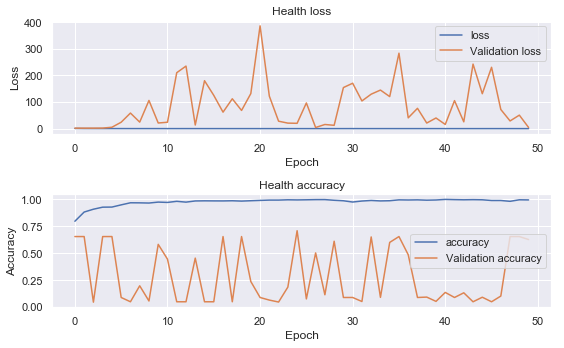

In [77]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training4.history['loss'], label='loss')
ax[0].plot(training4.history['val_loss'], label='Validation loss')
ax[0].set_title('Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training4.history['accuracy'], label='accuracy')
ax[1].plot(training4.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

### Test accuracy and loss

In [238]:
test_accuracy_report(model4)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                            precision    recall  f1-score   support

                   healthy       0.72      0.87      0.79       677
  few varrao, hive beetles       0.60      0.13      0.21       116
Varroa, Small Hive Beetles       0.33      0.01      0.02        95
              ant problems       0.78      0.23      0.36        91
         hive being robbed       0.17      0.54      0.26        50
             missing queen       0.00      0.00      0.00         6

                 micro avg       0.63      0.63      0.63      1035
                 macro avg       0.43      0.30      0.27      1035
              weighted avg       0.64      0.63      0.59      1035

Loss function: 4.599695956879768, accuracy: 0.6328502297401428


This model is worse than the previous one. Even though the loss score improves, its accuracy score decreases dramatically. I will reduce the learning rate to see if it can help reducing the validation loss and help with the overfitting problem.

## Smaller Learning Rate 

In [79]:
def train_cnn1():
    # to combat overfitting, better optimization for CNN, we'll be using Batch normalization prior to activation
    model = Sequential()
    
    #3x3 matrix with 11 feature maps in total, conventional 3d array for colored img, RBG. 255 in term of intensity max/min
    model.add(Conv2D(11,3,3, input_shape=(img_width, img_height,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    model.add(Conv2D(21,3,3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    # 3rd convo layer with more feature filter size, 41 for better dectection
    model.add(Conv2D(41,3,3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
    
    # flattening to input the fully connected layers
    model.add(Flatten())
    
    # dense layer section with hidden layer 200
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    
    # smaller learning rate to optimize better
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [80]:
model5 = train_cnn1()
training5 = model5.fit(np.array(X_train), np.array(Y_train), validation_data= (np.array(X_val), np.array(Y_val)), verbose=True, shuffle=True, epochs=50)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(100, 100,...)`
  
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(41, (3, 3), activation="relu")`


Train on 3309 samples, validate on 828 samples
Epoch 1/50
3309/3309 [==============================] - 45s 14ms/step - loss: 0.6160 - accuracy: 0.7821 - val_loss: 1.7846 - val_accuracy: 0.6546
Epoch 2/50
3309/3309 [==============================] - 43s 13ms/step - loss: 0.2923 - accuracy: 0.8906 - val_loss: 1.7793 - val_accuracy: 0.6546
Epoch 3/50
3309/3309 [==============================] - 45s 14ms/step - loss: 0.2011 - accuracy: 0.9232 - val_loss: 1.7378 - val_accuracy: 0.6534
Epoch 4/50
3309/3309 [==============================] - 44s 13ms/step - loss: 0.1466 - accuracy: 0.9456 - val_loss: 1.7340 - val_accuracy: 0.6546
Epoch 5/50
3309/3309 [==============================] - 46s 14ms/step - loss: 0.1163 - accuracy: 0.9571 - val_loss: 1.3939 - val_accuracy: 0.7114
Epoch 6/50
3309/3309 [==============================] - 47s 14ms/step - loss: 0.0906 - accuracy: 0.9680 - val_loss: 3.7742 - val_accuracy: 0.1292
Epoch 7/50
3309/3309 [==============================] - 46s 14ms/step - loss:

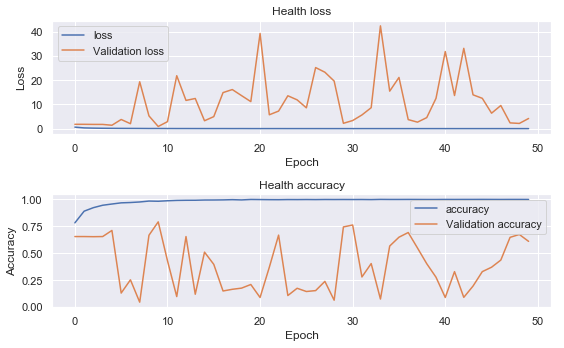

In [81]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training5.history['loss'], label='loss')
ax[0].plot(training5.history['val_loss'], label='Validation loss')
ax[0].set_title('Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training5.history['accuracy'], label='accuracy')
ax[1].plot(training5.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [235]:
test_accuracy_report(model5)

                            precision    recall  f1-score   support

                   healthy       0.83      0.70      0.76       677
  few varrao, hive beetles       0.71      0.25      0.37       116
Varroa, Small Hive Beetles       0.53      0.17      0.26        95
              ant problems       0.26      0.92      0.41        91
         hive being robbed       0.38      0.50      0.43        50
             missing queen       1.00      0.67      0.80         6

                 micro avg       0.61      0.61      0.61      1035
                 macro avg       0.62      0.53      0.50      1035
              weighted avg       0.72      0.61      0.62      1035

Loss function: 4.19749251794124, accuracy: 0.6096618175506592


Overall, the model isn't terrible, its accuracy decreases and so does its loss, compared to the vanilla prior to the optimizer change.

What we have learned on our model ? After playing around with a lot of filter sizes and dropouts/batch normalization (with the general rules of starting out with small # of filters, and increase them as we make the output of each conv layers smaller, as each filter is now more responsible for more detailed inspection the further down we go), we have a somewhat accurate prediction with an overfitting problem. The data begins to overfit around epoch #10. The model stopped learning when our validation loss stopped decreasing.

Also, it's worth to note that there's an optimization problem(spikes on val accuracy, perhaps with limited dataset - these images aren't a lot to work it, especially on the minority targets. The fix for this was to reduce the learning rate from 0.001 to 0.0001).

The first model will be used from hereon. Let's first addressing the class imbalance to see if we can improve the model's performance.

## Addressing Class Imbalance

### Down Sampling

In [140]:
def downsampling(df, X_pics, y):
    df['pixels'] = [np.array(image.img_to_array(i)) for i in X_pics]
    df['pixels'] = df['pixels']/255.0
    df['target'] = y
    
    # balance by health in the training set
    df_train, temp1, temp2, temp3, temp4, temp5 = splitting_dataset(df,y)
    num_cat = int(len(df_train)/df_train['health'].cat.categories.size)
    df_train = df_train.groupby('health', as_index=False).apply(lambda x: x.sample(num_cat, replace=True)).reset_index(drop=True)
    return(df_train)

In [126]:
def splitting_dataset(X,y):
    print('original \n',pd.Series(y).value_counts(normalize=True))
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

In [141]:
df_down = downsampling(bees,X_pics,y)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64


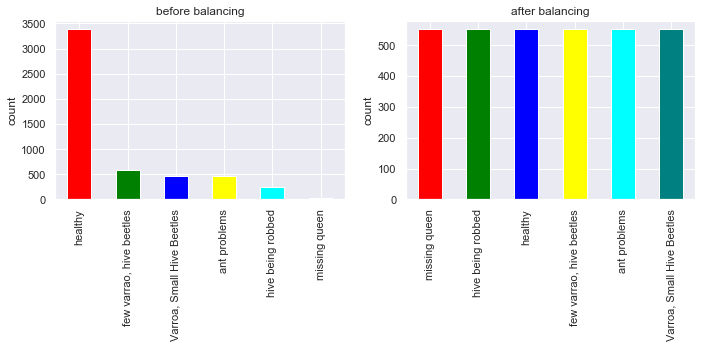

In [143]:
f, axs = plt.subplots(1,2, figsize=(10,5))
ax = bees.health.value_counts().plot(kind='bar', ax=axs[0], color=['red', 'green', 'blue', 'yellow', 'cyan', 'teal'])
ax.set_title('before balancing')
ax.set_ylabel('count')
    
ax = df_down.health.value_counts().plot(kind='bar', ax=axs[1], color=['red', 'green', 'blue', 'yellow', 'cyan', 'teal'])
ax.set_title('after balancing')
ax.set_ylabel('count')
    
plt.tight_layout()
plt.show()

In [144]:
X_downsampled = df_down.pixels.tolist()
y_downsampled = [y_keys[i] for i in df_down['health']]

In [212]:
model2 = train_cnn0()
training2 = model2.fit(np.array(X_downsampled), np.array(y_downsampled), 
                         validation_data=(np.array(X_val), np.array(Y_val)),
                         verbose=True,epochs=50)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(100, 100,...)`
  if __name__ == '__main__':
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), activation="relu")`
  del sys.path[0]
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`


Train on 3306 samples, validate on 828 samples
Epoch 1/50
3306/3306 [==============================] - 14s 4ms/step - loss: 1.1072 - accuracy: 0.5608 - val_loss: 1.5256 - val_accuracy: 0.6546
Epoch 2/50
3306/3306 [==============================] - 14s 4ms/step - loss: 0.5830 - accuracy: 0.7716 - val_loss: 2.2737 - val_accuracy: 0.6546
Epoch 3/50
3306/3306 [==============================] - 16s 5ms/step - loss: 0.3931 - accuracy: 0.8488 - val_loss: 2.6794 - val_accuracy: 0.6546
Epoch 4/50
3306/3306 [==============================] - 16s 5ms/step - loss: 0.3462 - accuracy: 0.8672 - val_loss: 2.4479 - val_accuracy: 0.6546
Epoch 5/50
3306/3306 [==============================] - 15s 5ms/step - loss: 0.2443 - accuracy: 0.9093 - val_loss: 3.0035 - val_accuracy: 0.6546
Epoch 6/50
3306/3306 [==============================] - 15s 5ms/step - loss: 0.2140 - accuracy: 0.9180 - val_loss: 2.9033 - val_accuracy: 0.6546
Epoch 7/50
3306/3306 [==============================] - 16s 5ms/step - loss: 0.1892

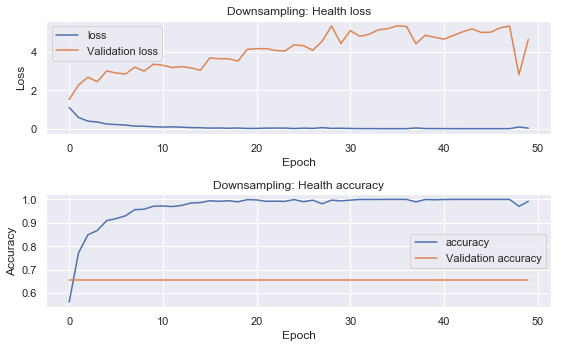

In [213]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training2.history['loss'], label='loss')
ax[0].plot(training2.history['val_loss'], label='Validation loss')
ax[0].set_title('Downsampling: Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training2.history['accuracy'], label='accuracy')
ax[1].plot(training2.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Downsampling: Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [214]:
test_accuracy_report(model2)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                            precision    recall  f1-score   support

                   healthy       0.65      1.00      0.79       677
  few varrao, hive beetles       0.00      0.00      0.00       116
Varroa, Small Hive Beetles       0.00      0.00      0.00        95
              ant problems       0.00      0.00      0.00        91
         hive being robbed       0.00      0.00      0.00        50
             missing queen       0.00      0.00      0.00         6

                 micro avg       0.65      0.65      0.65      1035
                 macro avg       0.11      0.17      0.13      1035
              weighted avg       0.43      0.65      0.52      1035

Loss function: 4.669880463420481, accuracy: 0.6541062593460083


`Downsampling` doesn't work too well, especially since many health variables being cut down to match the minority sample. Prediction accuracy drops, and loss score increases. The model also isn't capable of recognizing any other minority health statuses, and only the majority one.

Let's improve the current condition with 2 options: generating extra images on our data set and upsampling our dataset. Due to the limited computing resources, the pre-existing CNN architecture will be used.

## Image Augmentation

In [83]:
# data augmentation. Generating additional data for testing
def data_aug(X_train):
    datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.3,
        height_shift_range=0.3)
    
    datagen.fit(X_train)
    return datagen

datagen = data_aug(X_train)

In [215]:
model6a = train_cnn0()
training6a = model6a.fit_generator(datagen.flow(np.array(X_train), np.array(Y_train), batch_size=100),
                                             validation_data= (np.array(X_val), np.array(Y_val)),
                                             steps_per_epoch=len(X_train)/50, epochs=20)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(100, 100,...)`
  if __name__ == '__main__':
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), activation="relu")`
  del sys.path[0]
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`


Epoch 1/20
67/66 [==============================] - 32s 482ms/step - loss: 1.2154 - accuracy: 0.6461 - val_loss: 1.1349 - val_accuracy: 0.6546
Epoch 2/20
67/66 [==============================] - 31s 465ms/step - loss: 1.1699 - accuracy: 0.6516 - val_loss: 1.1373 - val_accuracy: 0.6546
Epoch 3/20
67/66 [==============================] - 32s 477ms/step - loss: 1.1339 - accuracy: 0.6574 - val_loss: 1.1299 - val_accuracy: 0.6546
Epoch 4/20
67/66 [==============================] - 29s 439ms/step - loss: 1.1287 - accuracy: 0.6533 - val_loss: 1.1275 - val_accuracy: 0.6546
Epoch 5/20
67/66 [==============================] - 29s 440ms/step - loss: 1.1199 - accuracy: 0.6545 - val_loss: 1.1215 - val_accuracy: 0.6546
Epoch 6/20
67/66 [==============================] - 30s 447ms/step - loss: 1.1139 - accuracy: 0.6559 - val_loss: 1.1079 - val_accuracy: 0.6546
Epoch 7/20
67/66 [==============================] - 30s 442ms/step - loss: 1.0737 - accuracy: 0.6546 - val_loss: 1.0497 - val_accuracy: 0.6546

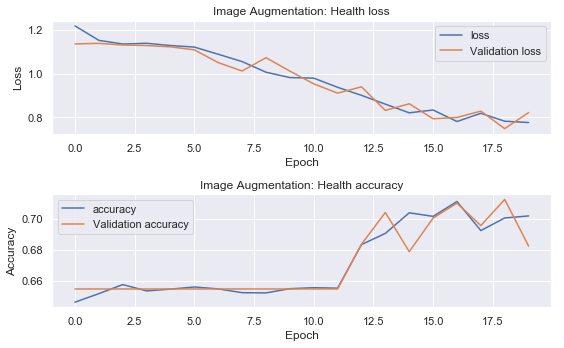

In [217]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training6a.history['loss'], label='loss')
ax[0].plot(training6a.history['val_loss'], label='Validation loss')
ax[0].set_title('Image Augmentation: Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training6a.history['accuracy'], label='accuracy')
ax[1].plot(training6a.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Image Augmentation: Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [218]:
test_accuracy_report(model6a)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                            precision    recall  f1-score   support

                   healthy       0.79      0.92      0.85       677
  few varrao, hive beetles       0.26      0.28      0.27       116
Varroa, Small Hive Beetles       0.50      0.58      0.54        95
              ant problems       0.00      0.00      0.00        91
         hive being robbed       0.44      0.14      0.21        50
             missing queen       0.00      0.00      0.00         6

                 micro avg       0.69      0.69      0.69      1035
                 macro avg       0.33      0.32      0.31      1035
              weighted avg       0.61      0.69      0.65      1035

Loss function: 0.8102844034991978, accuracy: 0.6927536129951477


`Image Augmentation` has better accuracy score than `Downsampling`. It can also recalls other minority health statuses compared to none in `Downsampling`. However, this is still not the best model yet so let's trying some other methods, like `Oversampling` and `Proportional Oversampling`. 

## Oversampling

In [88]:
def oversampling(df, X_pics, y):
    df['pixels'] = [np.array(image.img_to_array(i)) for i in X_pics]
    df['pixels'] = df['pixels']/255.0
    df['target'] = y
    
    df_train, temp1, temp2, temp3, temp4, temp5 = splitting_dataset(df,y)
    max_size = df_train['health'].value_counts().max()
    lst = [df_train]
    for classification, group in df_train.groupby('health'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df_new = pd.concat(lst)
    return df_new

In [89]:
new_bees = oversampling(bees,X_pics,y)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64


In [90]:
print(new_bees.health.value_counts())

missing queen                 2165
hive being robbed             2165
healthy                       2165
few varrao, hive beetles      2165
ant problems                  2165
Varroa, Small Hive Beetles    2165
Name: health, dtype: int64


In [91]:
new_bees.pixels.head()

1672    [[[0.5137255, 0.67058825, 0.5803922], [0.51372...
308     [[[0.5372549, 0.32156864, 0.10980392], [0.5568...
4615    [[[0.44313726, 0.5921569, 0.56078434], [0.4431...
2668    [[[0.827451, 0.8352941, 0.8352941], [0.827451,...
3443    [[[0.46666667, 0.44313726, 0.41568628], [0.466...
Name: pixels, dtype: object

In [92]:
x_upsampling = new_bees.pixels.tolist()
y_upsampling = [y_keys[i] for i in new_bees['health']]

In [219]:
model7a = train_cnn0()
training7a = model7a.fit(np.array(x_upsampling), np.array(y_upsampling), 
                         validation_data=(np.array(X_val), np.array(Y_val)),
                         verbose=True, shuffle=True, epochs=50)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(100, 100,...)`
  if __name__ == '__main__':
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), activation="relu")`
  del sys.path[0]
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`


Train on 12990 samples, validate on 828 samples
Epoch 1/50
12990/12990 [==============================] - 56s 4ms/step - loss: 0.6763 - accuracy: 0.7253 - val_loss: 1.5249 - val_accuracy: 0.6546
Epoch 2/50
12990/12990 [==============================] - 56s 4ms/step - loss: 0.2562 - accuracy: 0.8975 - val_loss: 2.0757 - val_accuracy: 0.6546
Epoch 3/50
12990/12990 [==============================] - 56s 4ms/step - loss: 0.1605 - accuracy: 0.9376 - val_loss: 2.4346 - val_accuracy: 0.6546
Epoch 4/50
12990/12990 [==============================] - 56s 4ms/step - loss: 0.1055 - accuracy: 0.9622 - val_loss: 3.1742 - val_accuracy: 0.6546
Epoch 5/50
12990/12990 [==============================] - 56s 4ms/step - loss: 0.0615 - accuracy: 0.9790 - val_loss: 3.6869 - val_accuracy: 0.6546
Epoch 6/50
12990/12990 [==============================] - 57s 4ms/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 4.6402 - val_accuracy: 0.6546
Epoch 7/50
12990/12990 [==============================] - 56s 4ms/step

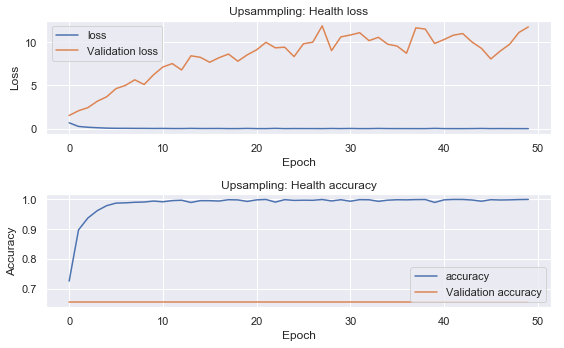

In [221]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training7a.history['loss'], label='loss')
ax[0].plot(training7a.history['val_loss'], label='Validation loss')
ax[0].set_title('Upsammpling: Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training7a.history['accuracy'], label='accuracy')
ax[1].plot(training7a.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Upsampling: Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [222]:
test_accuracy_report(model7a)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                            precision    recall  f1-score   support

                   healthy       0.65      1.00      0.79       677
  few varrao, hive beetles       0.00      0.00      0.00       116
Varroa, Small Hive Beetles       0.00      0.00      0.00        95
              ant problems       0.00      0.00      0.00        91
         hive being robbed       0.00      0.00      0.00        50
             missing queen       0.00      0.00      0.00         6

                 micro avg       0.65      0.65      0.65      1035
                 macro avg       0.11      0.17      0.13      1035
              weighted avg       0.43      0.65      0.52      1035

Loss function: 11.815518745016936, accuracy: 0.6541062593460083


It is well-known that we are exposed to overfitting with max upsampling. Copying sub 30 images of a "missing queen" category up to 2000+ data point won't help our model. It will overfit as it has only seen so many "queen" types images. The problem of high computation and overfitting has been associated with oversampling.

All in all, the validation loss has stopped very early on. Meaning our network isn't really learning anything new unfortunately. At that point, we also see a big divergence on our overfitting problem.

Case in point, don't use oversampling like this in a cnn.

## Proportional Oversampling

Instead of oversampling, in this case, lesser classes will be given higher weights. 

In [96]:
# ids1 = bees.health.value_counts().index.tolist()
# size1 = bees.health.value_counts().values

In [97]:
proportional_dict = {'healthy': 1,
                     'few varrao, hive beetles': 2,
                     'Varroa, Small Hive Beetles': 2,
                     'ant problems': 2,
                     'hive being robbed': 3,
                     'missing queen': 4}

In [98]:
def proportional_oversampling(df, X_pics, y, proportional_dict):
    df['pixels'] = [np.array(image.img_to_array(i)) for i in X_pics]
    df['pixels'] = df['pixels']/255.0
    df['target'] = y 
    
    df_train, temp1, temp2, temp3, temp4, temp5 = splitting_dataset(df,y)
    
    ids = df_train.health.value_counts().index.tolist()
    size = df_train.health.value_counts().values
    print('initial train set:\n', df_train.health.value_counts())
    result = []
    for i in range(len(ids)):
        df_sampled = df_train[df_train['health']==ids[i]].sample(n=(proportional_dict[ids[i]]*size[i]), replace=True, random_state=0)
        result.append(df_sampled)
    df_new = pd.concat(result)
    return df_new
        

In [99]:
prop_bees = proportional_oversampling(bees, X_pics, y, proportional_dict)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64
initial train set:
 healthy                       2165
few varrao, hive beetles       370
Varroa, Small Hive Beetles     302
ant problems                   293
hive being robbed              161
missing queen                   18
Name: health, dtype: int64


In [100]:
prop_bees.health.value_counts()

healthy                       2165
few varrao, hive beetles       740
Varroa, Small Hive Beetles     604
ant problems                   586
hive being robbed              483
missing queen                   72
Name: health, dtype: int64

In [101]:
X_trainp, X_testp, X_valp, Y_trainp, Y_testp, Y_valp = splitting_dataset(X,y)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64


In [102]:
X_prop = prop_bees.pixels.tolist()
y_prop = [y_keys[i] for i in prop_bees['health']]
datagen = data_aug(X_prop)

In [224]:
model8a = train_cnn0()
training8a = model8a.fit_generator(datagen.flow(np.array(X_prop), np.array(y_prop), batch_size=50),
                                 validation_data=(np.array(X_val), np.array(Y_val)),
                                 steps_per_epoch=len(X_train)/50, epochs=50)

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(100, 100,...)`
  if __name__ == '__main__':
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), activation="relu")`
  del sys.path[0]
C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`


Epoch 1/50
67/66 [==============================] - 22s 331ms/step - loss: 1.2213 - accuracy: 0.5319 - val_loss: 1.6102 - val_accuracy: 0.1123
Epoch 2/50
67/66 [==============================] - 19s 281ms/step - loss: 0.7286 - accuracy: 0.6931 - val_loss: 1.3967 - val_accuracy: 0.6546
Epoch 3/50
67/66 [==============================] - 22s 328ms/step - loss: 0.5940 - accuracy: 0.7400 - val_loss: 1.5690 - val_accuracy: 0.6546
Epoch 4/50
67/66 [==============================] - 20s 298ms/step - loss: 0.5351 - accuracy: 0.7493 - val_loss: 2.0225 - val_accuracy: 0.6546
Epoch 5/50
67/66 [==============================] - 17s 258ms/step - loss: 0.4935 - accuracy: 0.7699 - val_loss: 2.1206 - val_accuracy: 0.6546
Epoch 6/50
67/66 [==============================] - 19s 280ms/step - loss: 0.4204 - accuracy: 0.7991 - val_loss: 2.2201 - val_accuracy: 0.6546
Epoch 7/50
67/66 [==============================] - 20s 291ms/step - loss: 0.4130 - accuracy: 0.8096 - val_loss: 2.7161 - val_accuracy: 0.6546

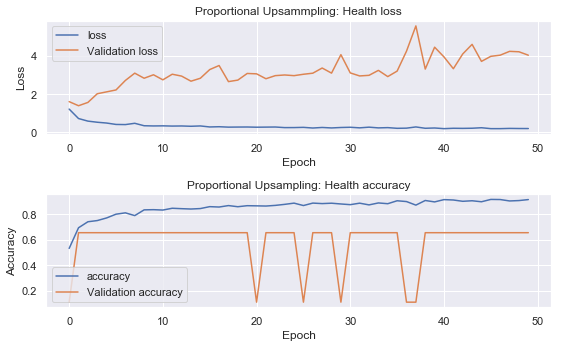

In [225]:
f, ax = plt.subplots(2,1, figsize=(8,5))

ax[0].plot(training8a.history['loss'], label='loss')
ax[0].plot(training8a.history['val_loss'], label='Validation loss')
ax[0].set_title('Proportional Upsammpling: Health loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training8a.history['accuracy'], label='accuracy')
ax[1].plot(training8a.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Proportional Upsampling: Health accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [226]:
test_accuracy_report(model8a)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                            precision    recall  f1-score   support

                   healthy       0.65      1.00      0.79       677
  few varrao, hive beetles       0.00      0.00      0.00       116
Varroa, Small Hive Beetles       0.00      0.00      0.00        95
              ant problems       0.00      0.00      0.00        91
         hive being robbed       0.00      0.00      0.00        50
             missing queen       0.00      0.00      0.00         6

                 micro avg       0.65      0.65      0.65      1035
                 macro avg       0.11      0.17      0.13      1035
              weighted avg       0.43      0.65      0.52      1035

Loss function: 4.039335180826233, accuracy: 0.6541062593460083


## Predictions

In [227]:
def multi_prediction(models, X_test, Y_test):
    preds = []
    for model in models:
        pred_ = model.predict(np.array(X_test))
        preds.append([np.argmax(i) for i in pred_])
        
    preds = pd.DataFrame(data=np.array(preds).T, columns=['model1','model4','model5', 'model2', 'model6a','model7a','model8a'])
    preds['target'] = Y_test
    preds['target'] = preds['target'].apply(np.argmax)
    return preds

In [228]:
predictions = multi_prediction([model1,model4,model5,model2,model6a,model7a,model8a],X_test,Y_test)
predictions.head(10)

,model1,model4,model5,model2,model6a,model7a,model8a,target
0,0,0,0,0,0,0,0,0
1,0,0,3,0,0,0,0,0
2,3,0,3,0,0,0,0,3
3,0,0,0,0,0,0,0,0
4,3,0,3,0,0,0,0,3
5,1,0,0,0,0,0,0,0
6,0,4,0,0,0,0,0,0
7,0,0,3,0,0,0,0,0
8,3,0,3,0,0,0,0,3
9,0,0,0,0,1,0,0,0


In [229]:
from sklearn.metrics import accuracy_score 


accuracy_1 = accuracy_score(predictions['model1'],predictions['target'])
accuracy_4 = accuracy_score(predictions['model4'],predictions['target'])
accuracy_5 = accuracy_score(predictions['model5'],predictions['target'])
accuracy_2 = accuracy_score(predictions['model2'],predictions['target'])
accuracy_6a = accuracy_score(predictions['model6a'],predictions['target'])
accuracy_7a = accuracy_score(predictions['model7a'],predictions['target'])
accuracy_8a = accuracy_score(predictions['model8a'],predictions['target'])


In [230]:
print(accuracy_1,accuracy_4,accuracy_5,accuracy_2,accuracy_6a,accuracy_7a,accuracy_8a)

0.8318840579710145 0.6328502415458938 0.6096618357487923 0.6541062801932367 0.6927536231884058 0.6541062801932367 0.6541062801932367


## Plotting accuracy per Health Status

In [231]:
def accuracy_table(df):
    # putting model names to a list
    models_list = df.columns.tolist()
    models_list.remove('target')
    health_cols = ['healthy','few varrao, hive beetles','Varroa, Small Hive Beetles','ant problem','hive being robbed', 'missing queen']
    accuracy = []
    
    for model in models_list:
        accuracy_list = []
        for i in range(6):
            size = (df['target']==i).sum()
            true = ((df[model]==i) & (df['target']==i)).sum()
            accuracy_list.append(true/size)
            
        accuracy.append(accuracy_list)
    accuracy = pd.DataFrame(accuracy, columns=health_cols)
    accuracy.index = models_list
    return accuracy

In [232]:
accuracy = accuracy_table(predictions)
accuracy

,healthy,"few varrao, hive beetles","Varroa, Small Hive Beetles",ant problem,hive being robbed,missing queen
model1,0.923191,0.586207,0.663158,0.846154,0.50,0.500000
model4,0.872969,0.129310,0.010526,0.230769,0.54,0.000000
model5,0.698671,0.250000,0.168421,0.923077,0.50,0.666667
model2,1.000000,0.000000,0.000000,0.000000,0.00,0.000000
model6a,0.920236,0.275862,0.578947,0.000000,0.14,0.000000
model7a,1.000000,0.000000,0.000000,0.000000,0.00,0.000000
model8a,1.000000,0.000000,0.000000,0.000000,0.00,0.000000


## Next steps

Even though the realtively simple CNN model achieved reasonable performance, I would like to explore the following options to further improve the model. More specifically, I would like to:

 * add few convolutional and pooling layers as well as batch normalization and drop some layers to avoid overfitting and to improve the CNN architecture.

 * use few other image pre-processing techniques such as flipping images horizontally or vertically, rotating, transforming images such as affine transformation, etc to explore whether those techniques improve accuracy.

 * explore more pre-trained models for this classification task.